In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
def read_files(path):
    file_contents = list()
    filenames = os.listdir(path)
    
    for i in range(len(filenames)):
        with open(path+filenames[i]) as f:
            file_contents.append(f.read())
    
    return file_contents

In [3]:
class_0 = read_files('20news-18828/comp.graphics/')
class_1 = read_files('20news-18828/rec.motorcycles/')
class_2 = read_files('20news-18828/sci.med/')
class_3 = read_files('20news-18828/talk.politics.misc/')

In [4]:
labels = ['comp.graphics', 'rec.motorcycles', 'sci.med', 'talk.politics.misc']

In [5]:
all_texts = np.append(class_0, class_1)
all_texts = np.append(all_texts, class_2)
all_texts = np.append(all_texts, class_3)

In [6]:
stop_words = set(stopwords.words('english'))
def clean(text):
    text = text.lower()
    text = re.sub('<[^>]*>', '', text)
    text = re.sub('\S*@\S*\s?', '', text)
    text = re.sub('https?://[A-Za-z0-9]','',text)
    text = re.sub('[^a-zA-Z]',' ',text)
    word_tokens = word_tokenize(text)    
    filtered_sentence = []
    for word_token in word_tokens:
        if word_token not in stop_words:
            filtered_sentence.append(word_token)
    
    text = (' '.join(filtered_sentence))
    return text

In [7]:
all_cleaned_texts = np.array([clean(text) for text in all_texts])

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

In [9]:
len(tokenizer.word_index)

35362

In [10]:
all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

<ipython-input-10-f9ff0a1669d7>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  all_encoded_texts = np.array(all_encoded_texts)


In [11]:
for i in range(5):
    print('Length of file', i, ':', len(all_encoded_texts[i]))

Length of file 0 : 205
Length of file 1 : 53
Length of file 2 : 113
Length of file 3 : 78
Length of file 4 : 49


In [12]:
all_encoded_texts = sequence.pad_sequences(all_encoded_texts, maxlen=500)

In [13]:
labels_0 = np.array([0] * len(class_0))
labels_1 = np.array([1] * len(class_1))
labels_2 = np.array([2] * len(class_2))
labels_3 = np.array([3] * len(class_3))

In [14]:
all_labels = np.append(labels_0, labels_1)
all_labels = np.append(all_labels, labels_2)
all_labels = np.append(all_labels, labels_3)

In [15]:
all_labels = all_labels[:, np.newaxis]
one_hot_encoder = OneHotEncoder(sparse=False)
all_labels = one_hot_encoder.fit_transform(all_labels)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, all_labels, test_size=0.2, random_state=11)

In [17]:
model = Sequential()
model.add(Embedding(input_dim=35363, output_dim=32, input_length=500))
model.add(LSTM(100))
model.add(Dense(4, activation='sigmoid'))

In [18]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=12, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/12
47/47 [==============================] - 45s 964ms/step - loss: 1.3538 - accuracy: 0.3401 - val_loss: 1.2241 - val_accuracy: 0.5890
Epoch 2/12
47/47 [==============================] - 43s 910ms/step - loss: 1.3771 - accuracy: 0.3412 - val_loss: 1.2657 - val_accuracy: 0.5797
Epoch 3/12
47/47 [==============================] - 43s 918ms/step - loss: 1.1176 - accuracy: 0.7775 - val_loss: 1.8202 - val_accuracy: 0.2704
Epoch 4/12
47/47 [==============================] - 43s 912ms/step - loss: 0.8749 - accuracy: 0.7497 - val_loss: 0.7528 - val_accuracy: 0.7604
Epoch 5/12
47/47 [==============================] - 43s 916ms/step - loss: 0.6047 - accuracy: 0.7966 - val_loss: 0.6757 - val_accuracy: 0.7269
Epoch 6/12
47/47 [==============================] - 43s 925ms/step - loss: 0.4817 - accuracy: 0.7942 - val_loss: 0.5304 - val_accuracy: 0.6988
Epoch 7/12
47/47 [==============================] - 44s 926ms/step - loss: 0.3774 - accuracy: 0.7919 - val_loss: 0.4753 - val_accuracy: 0.8742

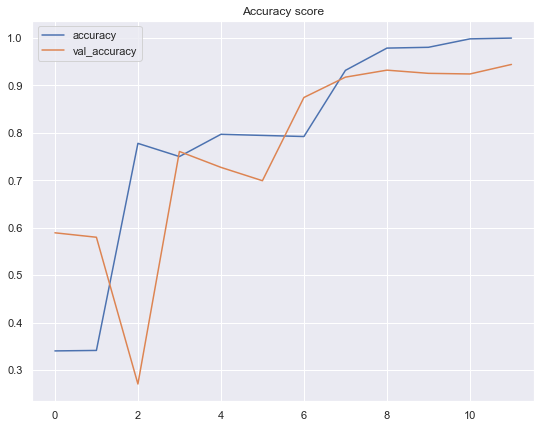

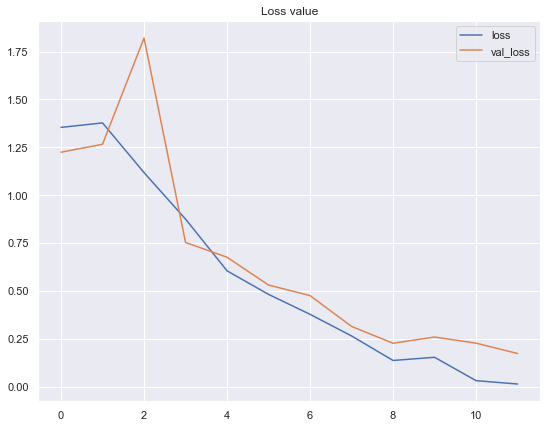

In [20]:
plt.figure(figsize=(9,7))
plt.title('Accuracy score')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(9,7))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [21]:
predictions = model.predict(X_test)
predictions = one_hot_encoder.inverse_transform(predictions)

In [22]:
y_test_evaluate = np.argmax(y_test, axis=1)

In [23]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 94.377512


In [24]:
cm = confusion_matrix(y_test_evaluate, predictions)

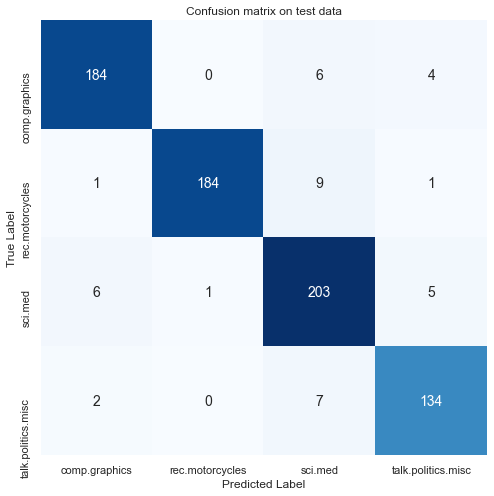

In [25]:
plt.figure(figsize=(8,8))
plt.title('Confusion matrix on test data')
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
string = 'I just purchased a new motorcycle, I feel like it is a lot better than cars'

In [27]:
cleaned_string = clean(string)

In [28]:
encoded_string = tokenizer.texts_to_sequences([cleaned_string])

In [29]:
encoded_string = sequence.pad_sequences(encoded_string, maxlen=500)

In [30]:
string_predict = model.predict(encoded_string)
np.argmax(string_predict)

1